In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# This notebook uses Spark to load an perform data transformations and combines interesting sections from these notebooks : 
#
# https://www.kaggle.com/mohaiminul101/car-price-prediction
# https://www.kaggle.com/aishu2218/do-you-wanna-predict-price-of-car-you-wanna-buy
# https://www.kaggle.com/udit1907/linear-advanced-regression-guided-car-purchase
#  
# These notebooks use 'Pandas' and 'scikit-learn'. This notebook here uses Spark to do the ETL and 
# then converts the Spark dataframe to a 'Pandas' dataframe (at the last minute) to do the visualization.
# Note that we are using regular 'Pandas' and not the newly available 'pyspark.pandas' in this notebook.


# Start Spark Session

In [3]:
# The simulated cluster environment is configured with : 
#   - 3 workers
#   - With 3GB of memory for each worker (Total memory is 9GB)
#   - Each worker has 2 cores (total cores is 6)

# Start up Spark session. Let's be greedy and ask for all available resources (We'll be explicit).

# Request : 
#   - A maximum of 6 cores with 
#   - 2 cores per executor
#   - 3 GB of memory per executor

# We also want to tell Spark about a specific java .jar file which contains a user defined function 
# we want to use later.

In [4]:
spark = SparkSession\
            .builder\
            .master("spark://spark-master:7077")\
            .appName("1_car_data_ETL_jupyter")\
            .config("spark.executor.cores", "2")\
            .config("spark.cores.max", "6")\
            .config("spark.executor.memory", "3G")\
            .config("spark.driver.memory", "2G")\
            .config('spark.jars', '/src/java/spark-jobs/helloworld/target/jv_helloworld-1.0-SNAPSHOT.jar')\
            .config('spark.executor.extraClassPath', '/src/java/spark-jobs/helloworld/target/jv_helloworld-1.0-SNAPSHOT.jar')\
            .getOrCreate()


22/04/01 14:33:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [5]:
# Add jar to java spark context. It has a UDF that I want to use later.

spark._jsc.addJar("/src/java/spark-jobs/helloworld/target/jv_helloworld-1.0-SNAPSHOT.jar")


In [6]:
# Register the java function. It will be available as StringLengthUDF (in the spark.sql command).

spark.udf.registerJavaFunction("StringLengthUDF", "ca.nrc.udf.StringLengthUDF", T.LongType())


In [7]:
# Tell Spark to use Apache Arrow

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

# About the Data ... 
The **car_data.csv** file contains information about used cars. We'll use this data for the purposes of vehicle price prediction.

### Columns and Descriptions
* **Car_Name** :      The name of the car.
* **Year** :          The year in which the car was bought.
* **Selling_Price** : The price the owner wants to sell the car at.
* **Present_Price** : The current ex-showroom price of the car.
* **Kms_Driven** :    The distance completed by the car in km.
* **Fuel_Type** :     Fuel type of the car.
* **Seller_Type** :   Whether the seller is a dealer or an individual.
* **Transmission** :   Whether the car is manual or automatic.
* **Owner** :          The number of owners the car has previously had.

# Read Raw Car Sales Data

In [8]:
# Read in the data. We don't ask Spark to determine the column data types. 
# This can add time to the job. We can give it a schema in the read command 
# or we can cast these once loaded. 

# Here, we'll cast the columns to the appropriate types once loaded.


In [9]:
# Reference : https://spark.apache.org/docs/latest/sql-data-sources-csv.html

car_df = spark\
    .read\
    .option("header", True)\
    .option("delimiter", ",")\
    .option("inferSchema", False)\
    .csv("/data/car_data.csv")


In [10]:
# Get number of rows and columns in the dataframe

print('Rows: {}, Columns: {}'.format(car_df.count(), len(car_df.columns)))


Rows: 301, Columns: 9


In [11]:
# Print the dataframe schema.

car_df.printSchema()


root
 |-- Car_Name: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Selling_Price: string (nullable = true)
 |-- Present_Price: string (nullable = true)
 |-- Kms_Driven: string (nullable = true)
 |-- Fuel_Type: string (nullable = true)
 |-- Seller_Type: string (nullable = true)
 |-- Transmission: string (nullable = true)
 |-- Owner: string (nullable = true)



In [12]:
# Show a few sample records. 

# Note that Prices are in lakh units. 
# https://en.wikipedia.org/wiki/Lakh ... 

# A lakh, in Indian numbering system, is equal to one hundred thousand. 
# For example, in India 150,000 rupees becomes 1.5 lakh rupees.

car_df.show(5, False)


+--------+----+-------------+-------------+----------+---------+-----------+------------+-----+
|Car_Name|Year|Selling_Price|Present_Price|Kms_Driven|Fuel_Type|Seller_Type|Transmission|Owner|
+--------+----+-------------+-------------+----------+---------+-----------+------------+-----+
|ritz    |2014|3.35         |5.59         |27000     |Petrol   |Dealer     |Manual      |0    |
|sx4     |2013|4.75         |9.54         |43000     |Diesel   |Dealer     |Manual      |0    |
|ciaz    |2017|7.25         |9.85         |6900      |Petrol   |Dealer     |Manual      |0    |
|wagon r |2011|2.85         |4.15         |5200      |Petrol   |Dealer     |Manual      |0    |
|swift   |2014|4.6          |6.87         |42450     |Diesel   |Dealer     |Manual      |0    |
+--------+----+-------------+-------------+----------+---------+-----------+------------+-----+
only showing top 5 rows



# Partitioning

In [13]:
# Partitions are basic units of parallelism in Apache Spark. 

In [14]:
# With too few partitions, the application won’t utilize all the cores available in the cluster.

In [15]:
# In Spark, by default, a partition is created for every HDFS partition of size 64MB. 
# RDDs are automatically partitioned in spark without human intervention. 
# However, we can change the partitioning scheme if we want. Note that there is a cost to shuffling data.

![partitions](media/partitioning.png)

In [16]:
# What is the current partitioning scheme ? 

print('Number of partitions for car_df dataframe. Before repartition : {}'.format(car_df.rdd.getNumPartitions()))


# Show the number of records per partition before the shuffle. 

car_df\
    .withColumn("partitionId", F.spark_partition_id())\
    .groupBy("partitionId")\
    .count()\
    .orderBy(F.asc("count"))\
    .show()


Number of partitions for car_df dataframe. Before repartition : 1


+-----------+-----+
|partitionId|count|
+-----------+-----+
|          0|  301|
+-----------+-----+



In [17]:
# Repartition data. Shuffle data to where we have as many partitions as the number of available core
# (e.g. 6 in this case because our cluster is configured with 6 cores).

car_df = car_df.repartition(6) 


# Show the number of records per partition after the shuffle.

print('Number of partitions for car_df dataframe. After repartition : {}'.format(car_df.rdd.getNumPartitions()))

car_df\
    .withColumn("partitionId", F.spark_partition_id())\
    .groupBy("partitionId")\
    .count()\
    .orderBy(F.asc("partitionId"))\
    .show()


Number of partitions for car_df dataframe. After repartition : 6


+-----------+-----+
|partitionId|count|
+-----------+-----+
|          0|   50|
|          1|   51|
|          2|   50|
|          3|   50|
|          4|   50|
|          5|   50|
+-----------+-----+



# DataFrames API - Selection, Aggregation, Filtering

In [18]:
# We can do any number of transformations using the DataFrames API.
# This is to give you an idea of what interacting with dataframes looks like.

# What kind of fuels the vehicles run on (Selection, Aggregation) ?

fuels_df = car_df\
    .select('Fuel_Type')\
    .groupBy('Fuel_Type')\
    .agg(F.count("Fuel_Type").alias('number_of_vehicles'))\
    .orderBy(F.col('number_of_vehicles').desc())

fuels_df.show()


+---------+------------------+
|Fuel_Type|number_of_vehicles|
+---------+------------------+
|   Petrol|               239|
|   Diesel|                60|
|      CNG|                 2|
+---------+------------------+



In [19]:
# We can do the same with a temporary table and a SQL query:

# Register the car_df DataFrame as a SQL temporary view
car_df.createOrReplaceTempView("CAR_TABLE")


# What kind of fuels the vehicles run on (Selection, Aggregation) ?

# Create the fuels_df DataFrame using Standard SQL query
fuels_df = spark.sql('''
    SELECT
        Fuel_Type,
        COUNT(1) AS number_of_vehicles
    FROM 
        CAR_TABLE
    GROUP BY
        Fuel_Type
    ORDER BY
        number_of_vehicles
    DESC
''')

fuels_df.show()


+---------+------------------+
|Fuel_Type|number_of_vehicles|
+---------+------------------+
|   Petrol|               239|
|   Diesel|                60|
|      CNG|                 2|
+---------+------------------+



In [20]:
# Filtering example :

# Cars selling for over 30 lakh rupees. 

car_df\
    .filter(F.col('Selling_Price').cast(T.DoubleType()) >= '30.0')\
    .show()

# Note that we have to cast the Selling_Price as a double. It's still a string at this point.
# We will fix this permanently in the next section.


+------------+----+-------------+-------------+----------+---------+-----------+------------+-----+
|    Car_Name|Year|Selling_Price|Present_Price|Kms_Driven|Fuel_Type|Seller_Type|Transmission|Owner|
+------------+----+-------------+-------------+----------+---------+-----------+------------+-----+
|    fortuner|2017|           33|        36.23|      6000|   Diesel|     Dealer|   Automatic|    0|
|land cruiser|2010|           35|         92.6|     78000|   Diesel|     Dealer|      Manual|    0|
+------------+----+-------------+-------------+----------+---------+-----------+------------+-----+



In [21]:
# The point of the section above is : 

# Pandas is a very popular data analysis and manipulation tool.

# What you can do with Pandas transformations, you can do with Spark. 
# I would argue the PySpark APIs are easier to read and work with than the Pandas APIs.


# !! HOWEVER !! 

# If you still want to use a Pandas API but benefit from Spark's distributed architecture, 
# check out (Pandas API on Spark - used to be Koalas). This is new in Sparkk 3.2.

# https://databricks.com/blog/2021/10/04/pandas-api-on-upcoming-apache-spark-3-2.html

In [22]:
# More transformation examples can be found in the common_ops jupyter notebook included in the current GitHub project directory.

# Data Transformations for Downstream MLlib Example

In [23]:
# Assign proper types to certain column elements.

car_df = car_df\
    .withColumn('Year', car_df.Year.cast(T.IntegerType()))\
    .withColumn('Kms_Driven', car_df.Kms_Driven.cast(T.IntegerType()))\
    .withColumn('Owner', car_df.Owner.cast(T.IntegerType()))\
    .withColumn('Selling_Price', car_df.Selling_Price.cast(T.DoubleType()))\
    .withColumn('Present_Price', car_df.Present_Price.cast(T.DoubleType()))


In [24]:
# Check the schema to see the changes

car_df.printSchema()


root
 |-- Car_Name: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Selling_Price: double (nullable = true)
 |-- Present_Price: double (nullable = true)
 |-- Kms_Driven: integer (nullable = true)
 |-- Fuel_Type: string (nullable = true)
 |-- Seller_Type: string (nullable = true)
 |-- Transmission: string (nullable = true)
 |-- Owner: integer (nullable = true)



In [25]:
# Check to make sure that we have data in every column of every row.
# The query below counts all instances of null or nan in each colum of the car_df dataframe.

car_df.select(
    [F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in car_df.columns]
).show()


+--------+----+-------------+-------------+----------+---------+-----------+------------+-----+
|Car_Name|Year|Selling_Price|Present_Price|Kms_Driven|Fuel_Type|Seller_Type|Transmission|Owner|
+--------+----+-------------+-------------+----------+---------+-----------+------------+-----+
|       0|   0|            0|            0|         0|        0|          0|           0|    0|
+--------+----+-------------+-------------+----------+---------+-----------+------------+-----+



In [26]:
# Write and call a User Defined Function (UDF) written in Python 


# Write a function to calculate the age of a vehicle given year
def get_age(i_year):
    current_year = date.today().year

    if current_year < i_year:
        raise Exception('Problem with years')

    return current_year - i_year


# Create a user defined function (i.e. a user-programmable routine that act on one row).

calc_age_udf = F.udf(lambda year: get_age(year), T.IntegerType())


# Add an 'Car_Age' column to the car_df dataframe

car_df = car_df\
    .withColumn('Car_Age', calc_age_udf(F.col('Year')))

# We should see a 'Car_Age' column in at the end of our dataframe now.

car_df.show(5, False)


+------------------------+----+-------------+-------------+----------+---------+-----------+------------+-----+-------+
|Car_Name                |Year|Selling_Price|Present_Price|Kms_Driven|Fuel_Type|Seller_Type|Transmission|Owner|Car_Age|
+------------------------+----+-------------+-------------+----------+---------+-----------+------------+-----+-------+
|sx4                     |2008|1.95         |7.15         |58000     |Petrol   |Dealer     |Manual      |0    |14     |
|ciaz                    |2016|8.75         |8.89         |20273     |Diesel   |Dealer     |Manual      |0    |6      |
|i10                     |2011|2.55         |4.43         |57000     |Petrol   |Dealer     |Manual      |0    |11     |
|brio                    |2012|3.0          |5.35         |53675     |Petrol   |Dealer     |Manual      |0    |10     |
|Bajaj Avenger Street 220|2011|0.45         |0.95         |24000     |Petrol   |Individual |Manual      |0    |11     |
+------------------------+----+---------

In [27]:
# Call a UDF written in Java

# Add the first name length field (fname_length) by calling a Java function. 
# This function lives in the jar we added to Spark earlier.
car_df = car_df\
    .withColumn("car_name_length", F.expr("StringLengthUDF(Car_Name)"))

car_df.show(5, True)


+--------------------+----+-------------+-------------+----------+---------+-----------+------------+-----+-------+---------------+
|            Car_Name|Year|Selling_Price|Present_Price|Kms_Driven|Fuel_Type|Seller_Type|Transmission|Owner|Car_Age|car_name_length|
+--------------------+----+-------------+-------------+----------+---------+-----------+------------+-----+-------+---------------+
|                 sx4|2008|         1.95|         7.15|     58000|   Petrol|     Dealer|      Manual|    0|     14|              3|
|                ciaz|2016|         8.75|         8.89|     20273|   Diesel|     Dealer|      Manual|    0|      6|              4|
|                 i10|2011|         2.55|         4.43|     57000|   Petrol|     Dealer|      Manual|    0|     11|              3|
|                brio|2012|          3.0|         5.35|     53675|   Petrol|     Dealer|      Manual|    0|     10|              4|
|Bajaj Avenger Str...|2011|         0.45|         0.95|     24000|   Petrol|

In [28]:
# One last simple tranformation example :

# Add calculated column. Create 'inflated_price' column, which is the ('Selling_Price' + 30 percent) :

car_df = car_df\
    .withColumn('inflated_price', F.col('Selling_Price')*F.lit(1.30))

car_df\
    .select('Car_Name', 'Selling_Price', 'Inflated_Price')\
    .show(5, False)


+-------------------------+-------------+------------------+
|Car_Name                 |Selling_Price|Inflated_Price    |
+-------------------------+-------------+------------------+
|Royal Enfield Classic 350|1.1          |1.4300000000000002|
|ciaz                     |7.45         |9.685             |
|Yamaha FZ S V 2.0        |0.55         |0.7150000000000001|
|Bajaj Pulsar RS200       |1.05         |1.3650000000000002|
|innova                   |18.0         |23.400000000000002|
+-------------------------+-------------+------------------+
only showing top 5 rows



In [29]:
# Drop a column we don't need .. in this case, the 'Inflated_Price' and 'car_name_length' columns we just added.

car_df = car_df\
    .drop('Inflated_Price')\
    .drop('car_name_length')

car_df.show(5, False)


+------------------------+----+-------------+-------------+----------+---------+-----------+------------+-----+-------+
|Car_Name                |Year|Selling_Price|Present_Price|Kms_Driven|Fuel_Type|Seller_Type|Transmission|Owner|Car_Age|
+------------------------+----+-------------+-------------+----------+---------+-----------+------------+-----+-------+
|sx4                     |2008|1.95         |7.15         |58000     |Petrol   |Dealer     |Manual      |0    |14     |
|ciaz                    |2016|8.75         |8.89         |20273     |Diesel   |Dealer     |Manual      |0    |6      |
|i10                     |2011|2.55         |4.43         |57000     |Petrol   |Dealer     |Manual      |0    |11     |
|brio                    |2012|3.0          |5.35         |53675     |Petrol   |Dealer     |Manual      |0    |10     |
|Bajaj Avenger Street 220|2011|0.45         |0.95         |24000     |Petrol   |Individual |Manual      |0    |11     |
+------------------------+----+---------

# Data Exploration

In [30]:
# Compute summary statistics for numeric columns.

car_df\
    .select('Selling_Price', 'Present_Price', 'Kms_Driven', 'Car_Age')\
    .summary()\
    .show()


+-------+-----------------+-----------------+-----------------+-----------------+
|summary|    Selling_Price|    Present_Price|       Kms_Driven|          Car_Age|
+-------+-----------------+-----------------+-----------------+-----------------+
|  count|              301|              301|              301|              301|
|   mean|4.661295681063123|7.628471760797341|36947.20598006644|8.372093023255815|
| stddev|5.082811556177803|8.644115402015787|38886.88388206788|2.891554127336687|
|    min|              0.1|             0.32|              500|                4|
|    25%|              0.9|              1.2|            15000|                6|
|    50%|              3.6|              6.4|            32000|                8|
|    75%|              6.0|              9.9|            48767|               10|
|    max|             35.0|             92.6|           500000|               19|
+-------+-----------------+-----------------+-----------------+-----------------+



In [31]:
# Convert the Spark dataframe to a native Pandas dataframe (for visualizations). 
# Note that we are NOT using the NEW Pandas API on Spark, which allows 
# you to scale your Pandas workload out. It's just straight Pandas.

car_pdf = car_df.toPandas()


In [32]:
# A SIDE NOTE ... APACHE ARROW

# If using Apacke Arrow, creating a Spark dataframe from a pandas dataframe is much quicker.
%time df = spark.createDataFrame(car_pdf)
print()
print()
# If using NOT using Apacke Arrow, creating a Spark dataframe from a pandas dataframe is much slower.
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")
%time df = spark.createDataFrame(car_pdf)

# Reset to use Apache Arrow
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

CPU times: user 24.1 ms, sys: 4.91 ms, total: 29 ms
Wall time: 68 ms


CPU times: user 49.1 ms, sys: 2.1 ms, total: 51.2 ms
Wall time: 105 ms


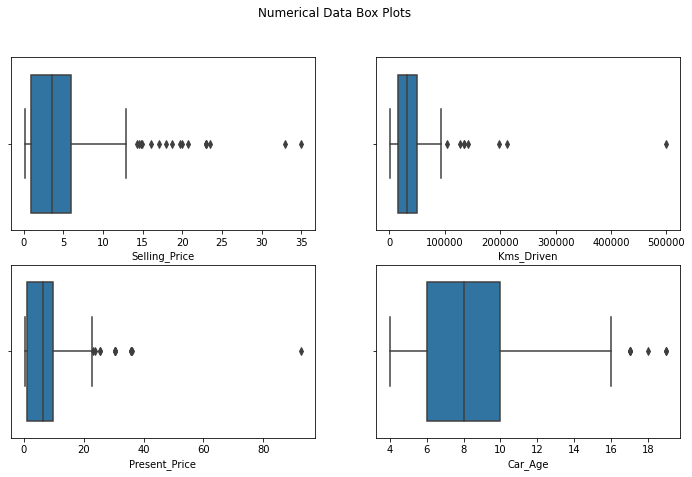

In [33]:
# Create boxplots for numerical data.

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 7))
fig.suptitle('Numerical Data Box Plots')

ax1 = sns.boxplot(x='Selling_Price', data=car_pdf, ax=ax1)
ax2 = sns.boxplot(x='Kms_Driven', data=car_pdf, ax=ax2)
ax3 = sns.boxplot(x='Present_Price', data=car_pdf, ax=ax3)
ax4 = sns.boxplot(x='Car_Age', data=car_pdf, ax=ax4)


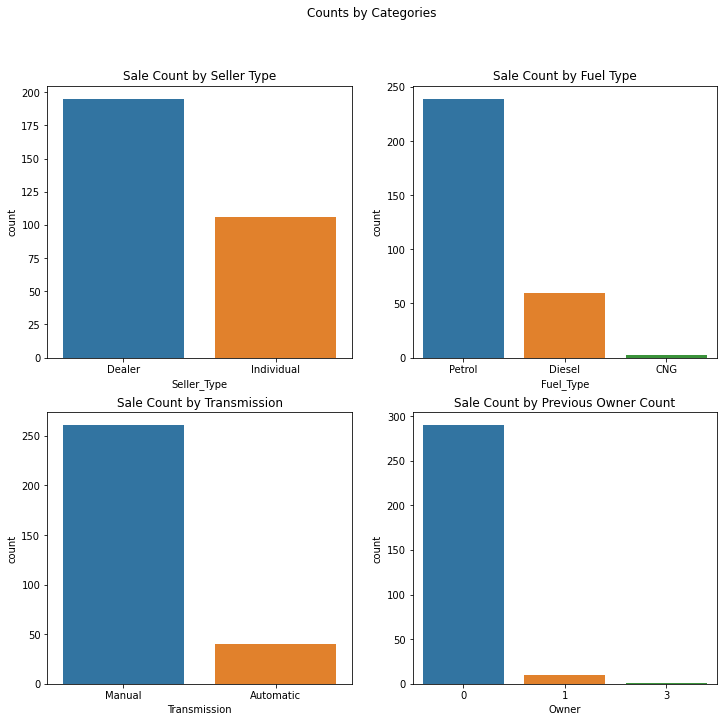

In [34]:
# Create bar charts for categorical data.

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 11))
fig.suptitle('Counts by Categories')

ax1 = sns.countplot(x='Seller_Type', data=car_pdf, ax=ax1).set_title('Sale Count by Seller Type')
ax2 = sns.countplot(x='Fuel_Type', data=car_pdf, ax=ax2).set_title('Sale Count by Fuel Type')
ax3 = sns.countplot(x='Transmission', data=car_pdf, ax=ax3).set_title('Sale Count by Transmission')
ax4 = sns.countplot(x='Owner', data=car_pdf, ax=ax4).set_title('Sale Count by Previous Owner Count')


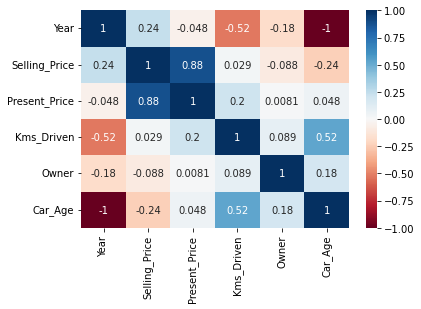

In [35]:
# Create correlation heatmap.

sns.heatmap(car_pdf.corr(), annot=True, cmap="RdBu")
plt.show()


<Figure size 720x720 with 0 Axes>

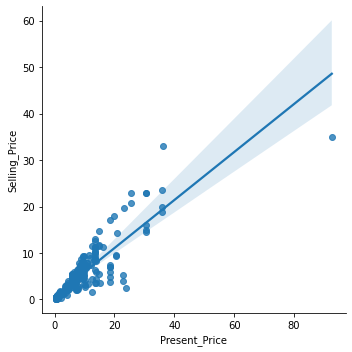

In [36]:
# Plot selling_price relative to present_price.

plt.figure(figsize=(10,10))
sns.lmplot(x='Present_Price',y='Selling_Price',data=car_pdf)


# Save the Spark Dataframe as a Parquet File for Downstream Use

In [37]:
# Show the schema of the dataframe we are saving

car_df.printSchema()


root
 |-- Car_Name: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Selling_Price: double (nullable = true)
 |-- Present_Price: double (nullable = true)
 |-- Kms_Driven: integer (nullable = true)
 |-- Fuel_Type: string (nullable = true)
 |-- Seller_Type: string (nullable = true)
 |-- Transmission: string (nullable = true)
 |-- Owner: integer (nullable = true)
 |-- Car_Age: integer (nullable = true)



In [38]:
car_df.write.mode("overwrite").parquet("/data/car_data.parquet")

In [39]:
%%bash

echo 'Current Linux User : (Should be ds...)'
whoami

echo ''
echo ''


# We can see the parquet file (6 partitions) was saved in the '/data' directory : 

echo 'List parquet file parts :'

ls /data/car_data.parquet


Current Linux User : (Should be ds...)
ds


List parquet file parts :
_SUCCESS
part-00000-b2eb307e-3e1a-4c52-b970-b7007c97c821-c000.snappy.parquet
part-00001-b2eb307e-3e1a-4c52-b970-b7007c97c821-c000.snappy.parquet
part-00002-b2eb307e-3e1a-4c52-b970-b7007c97c821-c000.snappy.parquet
part-00003-b2eb307e-3e1a-4c52-b970-b7007c97c821-c000.snappy.parquet
part-00004-b2eb307e-3e1a-4c52-b970-b7007c97c821-c000.snappy.parquet
part-00005-b2eb307e-3e1a-4c52-b970-b7007c97c821-c000.snappy.parquet


In [40]:
spark.stop()